<a href="https://colab.research.google.com/github/jooooojo/st5209/blob/master/rnn_with_vars_chn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import tensorflow as tf
from matplotlib import pyplot
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score
import os
import datetime
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard


In [32]:
tf.random.set_seed(51)
class G:
    SPLIT_TIME = 3767 # use data after 2018 as validation
    WINDOW_SIZE = 60
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    DATE_SPLIT = SPLIT_TIME + WINDOW_SIZE

In [33]:

data_set_frame = pd.read_csv('/content/drive/MyDrive/ST5188_data_for_code/Exchange_Rates_full.csv', header=0, squeeze=True)
dates = pd.to_datetime(data_set_frame['Date'])
data_set_frame = data_set_frame.iloc[:, 5:]
all_sheets_dict = pd.read_excel('/content/drive/MyDrive/ST5188_data_for_code/variable_interpolated.xlsx', sheet_name=None)

<ipython-input-33-c89c6402f14b>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data_set_frame = pd.read_csv('/content/drive/MyDrive/ST5188_data_for_code/Exchange_Rates_full.csv', header=0, squeeze=True)


In [34]:

def load_data(currency,data_set_frame):
    raw_data = []
    for data_point in data_set_frame[[currency]].values.tolist():
        raw_data.append(data_point[0])
    global LENGTH_DATA_SET
    LENGTH_DATA_SET = len(raw_data)
    raw_data = np.array(data_set_frame[currency])
    # print(data_set_frame['SGD/' + currency])
    # print(type(data_set_frame['SGD/' + currency]))
    return raw_data

In [35]:
# all_data_dict = {}


def load_economic_metrics(eco_matrix = 'GDP_per_capita', currency = 'SGP'):

  eco_matrix = all_sheets_dict[eco_matrix]
  eco_data = []
  for data_point in  eco_matrix[[currency]].values.tolist():
    # print(data_point[0])
    eco_data.append(data_point[0])
  # print(eco_data)
  return eco_data


In [36]:
def norm(dataset):
  columns = [cur for cur in dataset.columns.values.tolist()]
  for col in columns:
    scaler = StandardScaler()
    dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))

  return dataset,scaler


In [37]:
def get_wanted_variables(wanted_variable,currency):
  all_data_dict={}
  all_data_dict['Oil_price'] = load_economic_metrics('oil+gold','Oil_price')
  all_data_dict['Gold_price'] = load_economic_metrics('oil+gold','Gold_price')
  wanted_variable.remove('oil+gold')
  for variable in wanted_variable:
    all_data_dict[variable +'_' + currency] = load_economic_metrics(variable, currency)
    all_data_dict[variable +'_' + 'SGP'] = load_economic_metrics(variable)

  # for key,val in all_data_dict.items():
  #   print(key,val)
  # whole_data_set = pd.DataFrame(all_data_dict)
  # print(whole_data_set)
  return all_data_dict

In [38]:
def create_dataset(X, y, seq_len=G.WINDOW_SIZE):
    features = []
    targets = []

    for i in range(0, len(X) - seq_len, 1):
        data = X.iloc[i:i+seq_len]
        label = y.iloc[i+seq_len]

        features.append(data)
        targets.append(label)


    return np.array(features), np.array(targets)

In [39]:
def create_batch_dataset(X, y, train=True, buffer_size=G.SHUFFLE_BUFFER_SIZE, batch_size=G.BATCH_SIZE):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    if train:
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else:
        return batch_data.batch(batch_size)

In [40]:

def create_uncompiled_model_2(num_cols):
    ### START CODE HERE

    model = tf.keras.models.Sequential([
        # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None,7]),
        tf.keras.layers.SimpleRNN(64,input_shape=[G.WINDOW_SIZE,num_cols], return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SimpleRNN(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SimpleRNN(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SimpleRNN(32, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SimpleRNN(32),
        # tf.keras.layers.Dropout(0.3),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
        # tf.keras.layers.Lambda(lambda x: x * 100)
    ])
    return model


In [41]:
def create_model_2(model, num_cols):
    tf.random.set_seed(51)

    model = create_uncompiled_model_2(num_cols)

    ### START CODE HERE
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='mae',
                  optimizer='adam',
                  metrics=["mae"])

    ### END CODE HERE

    return model

In [42]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    r2= score = r2_score(true_series, forecast)

    return mse, mae, r2

In [28]:
def rnn_model_2(currency,data_set_frame,matrix,wanted_variable,hyper = ''): # this function contian other variables

    print('loading data of SGD/' + currency)
    series = load_data(currency,data_set_frame)
    time = np.arange(LENGTH_DATA_SET, dtype="float32")

    print('loading other economic indices')
    # wanted_variable = ['GDP_per_capita','Unemployment_perc_laborforce','CPI','Political_stability_estimate','Current_account_balance'] # and oil and gold price, and this does not applied to all countries

    all_data_dict= get_wanted_variables(wanted_variable,currency)
    all_data_dict['series'] = series
    whole_data_set = pd.DataFrame(all_data_dict)
    # print(whole_data_set.head())

    print('normalization')
    whole_data_set, scaler = norm(whole_data_set)
    print(whole_data_set.head())


    print('split data set')
    X_train, X_test, y_train, y_test = train_test_split(whole_data_set, whole_data_set['series'], test_size=(whole_data_set.shape[0] - G.SPLIT_TIME)/whole_data_set.shape[0], shuffle=False, random_state=666)
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


    print('create dataset')
    train_dataset, train_labels = create_dataset(X_train, y_train)
    test_dataset, test_labels = create_dataset(X_test, y_test)
    whole_dataset, whole_labels = create_dataset(whole_data_set, whole_data_set['series'])

    print(train_dataset.shape,train_labels.shape,test_dataset.shape,test_labels.shape)
    num_cols = train_dataset.shape[-1]
    print('create batch data')

    train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
    test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)
    whole_batch_dataset = create_batch_dataset(whole_dataset,whole_labels,train = False)
    # print('try scale back')
    # test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1)).squeeze()
    # print(test_labels)

    print('try model')
    uncompiled_model = create_uncompiled_model_2(num_cols)
    try:
        uncompiled_model.predict(train_batch_dataset)
    except:
        print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
    else:
        print("Your current architecture is compatible with the windowed dataset! :)")

    # print('adjust learning rate')
    # lr_history = adjust_learning_rate(train_batch_dataset,num_cols)
    # plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
    # plt.axis([1e-6, 1, 0, 30])

    model = create_model_2(uncompiled_model,num_cols)
    print('get log')
    !rm -rf logs

    log_file = os.path.join('logs', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    tensorboard_callback = TensorBoard(log_file)

    checkpoint_file = "best_model.hdf5"

    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file,
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)
    print('train it')
    history = model.fit(train_batch_dataset,
                    epochs=100,
                    validation_data=test_batch_dataset,
                    callbacks=[tensorboard_callback, checkpoint_callback])

    print('plot loss train')

    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Train loss V.S Value loss in SGD and ' + currency)
    plt.legend(loc='best')
    plt.savefig(file_path+'loss_train_'+ currency+'_'+ hyper + '.png')
    plt.show()

    # files.download('loss_train_'+ currency+'.png')

    test_preds = model.predict(test_batch_dataset)
    whole_preds = model.predict(whole_batch_dataset)

    # print(test_preds.shape)
    test_preds = test_preds[:, 0]
    whole_preds = whole_preds[:,0]

    print('scale back to the original data')
    test_preds = scaler.inverse_transform(test_preds.reshape(-1, 1)).squeeze()
    test_labels = scaler.inverse_transform(test_labels.reshape(-1, 1)).squeeze()
    whole_preds = scaler.inverse_transform(whole_preds.reshape(-1, 1)).squeeze()
    whole_labels = scaler.inverse_transform(whole_labels.reshape(-1, 1)).squeeze()


    print ('test plot')
    plt.figure(figsize=(16,8))
    plt.plot(dates[G.DATE_SPLIT-1:],test_labels[:], label="Actual", color = colors[currency])
    plt.plot(dates[G.DATE_SPLIT-1:],test_preds[:], label="Predicted", color = colors['Predict'])
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.title(currency + '/SGP Actual v.s. Predicted using RNN')
    plt.legend(loc='best')
    plt.xticks()
    plt.savefig(file_path+'SGD v.s'+ currency + '_'+ hyper + '.png')
    plt.show()

    print ('whole data plot')
    plt.figure(figsize=(16,8))
    plt.plot(whole_labels[:], label="Actual",  color = colors[currency])
    plt.plot(whole_preds[:], label="Predicted",  color = colors['Predict'])
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.axvline(x=G.SPLIT_TIME, color='r', linestyle='--')
    plt.title(currency + '/SGP Actual v.s. Predicted using RNN')
    plt.legend(loc='best')
    plt.xticks()
    plt.savefig(file_path+'SGD v.s'+ currency + '_whole_'+ hyper + '.png')
    plt.show()

    print("compute mae mse")
    mse, mae, R2 = compute_metrics(test_labels, test_preds)
    mse_A, mae_A, R2_A = compute_metrics(whole_labels, whole_preds)

    print(f"mse: {mse:.5f}, mae: {mae:.5f}, R^2:{R2} for forecast")
    print(f"mse_all: {mse_A:.5f}, mae_all: {mae_A:.5f}, R^2_all:{R2_A} for forecast")
    matrix[currency].append(mse)
    matrix[currency].append(mae)
    matrix[currency].append(R2)
    matrix[currency].append(mse_A)
    matrix[currency].append(mae_A)
    matrix[currency].append(R2_A)
    print(matrix)
    return matrix

In [15]:
file_path = '/content/drive/MyDrive/ST5188_data_for_code/image_no_event/'
matrix_dict = {}
tf.random.set_seed(51)
header_list = [cur for cur in data_set_frame.columns.values.tolist()]

QAT
loading data of SGD/QAT
loading other economic indices
normalization
   Oil_price  Gold_price  GDP_per_capita_QAT  GDP_per_capita_SGP  \
0  -1.533390   -1.773222           -1.730655           -1.730655   
1  -1.478721   -1.771751           -1.730197           -1.730197   
2  -1.519829   -1.756513           -1.728825           -1.728825   
3  -1.566022   -1.762293           -1.728368           -1.728368   
4  -1.588907   -1.760717           -1.727910           -1.727910   

   Net_trade_in_goods_QAT  Net_trade_in_goods_SGP  Net_financial_account_QAT  \
0                1.730655               -1.730655                   1.730655   
1                1.730197               -1.730197                   1.730197   
2                1.728825               -1.728825                   1.728825   
3                1.728368               -1.728368                   1.728368   
4                1.727910               -1.727910                   1.727910   

   Net_financial_account_SGP  Net_for

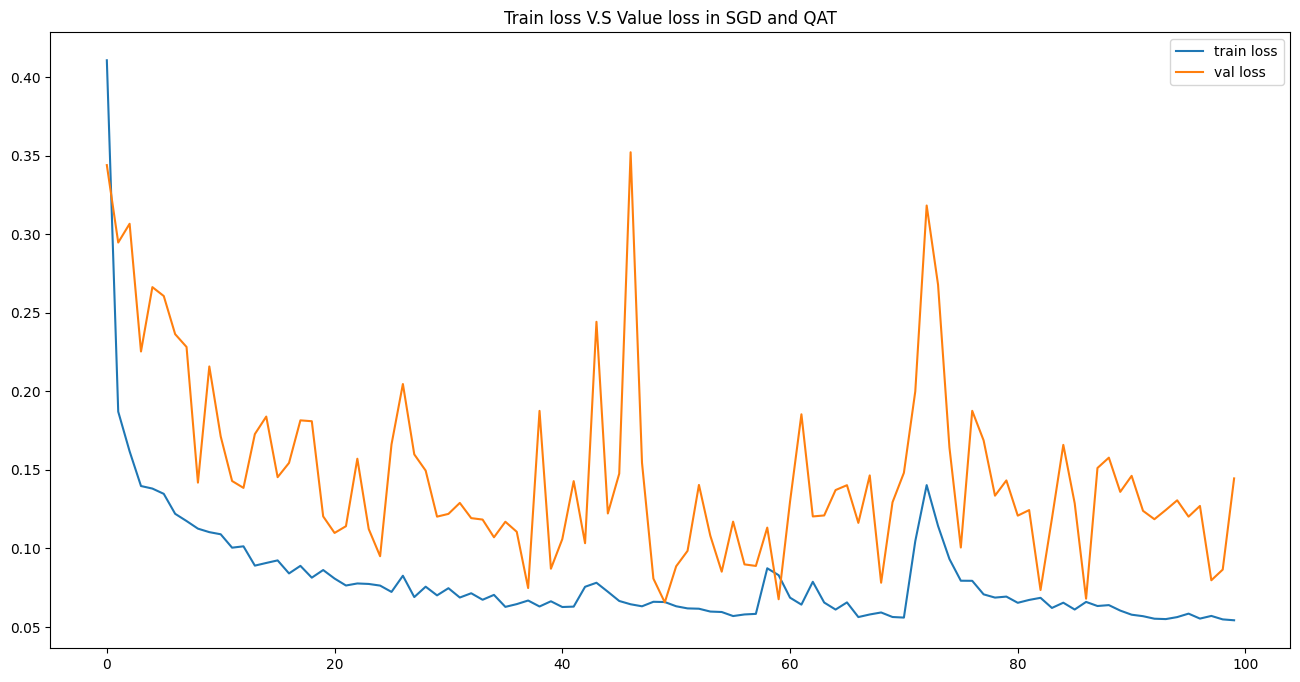

161/161 [==============================] - 2s 11ms/step
scale back to the original data
test plot


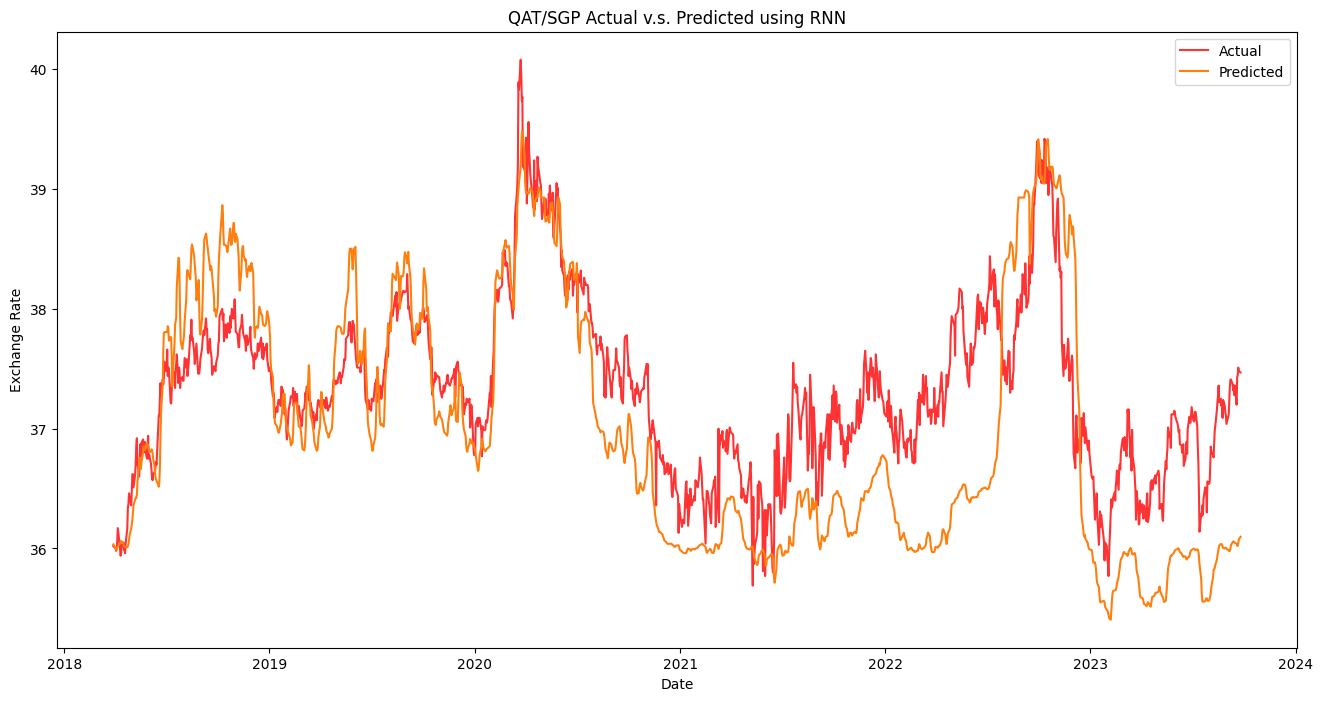

whole data plot


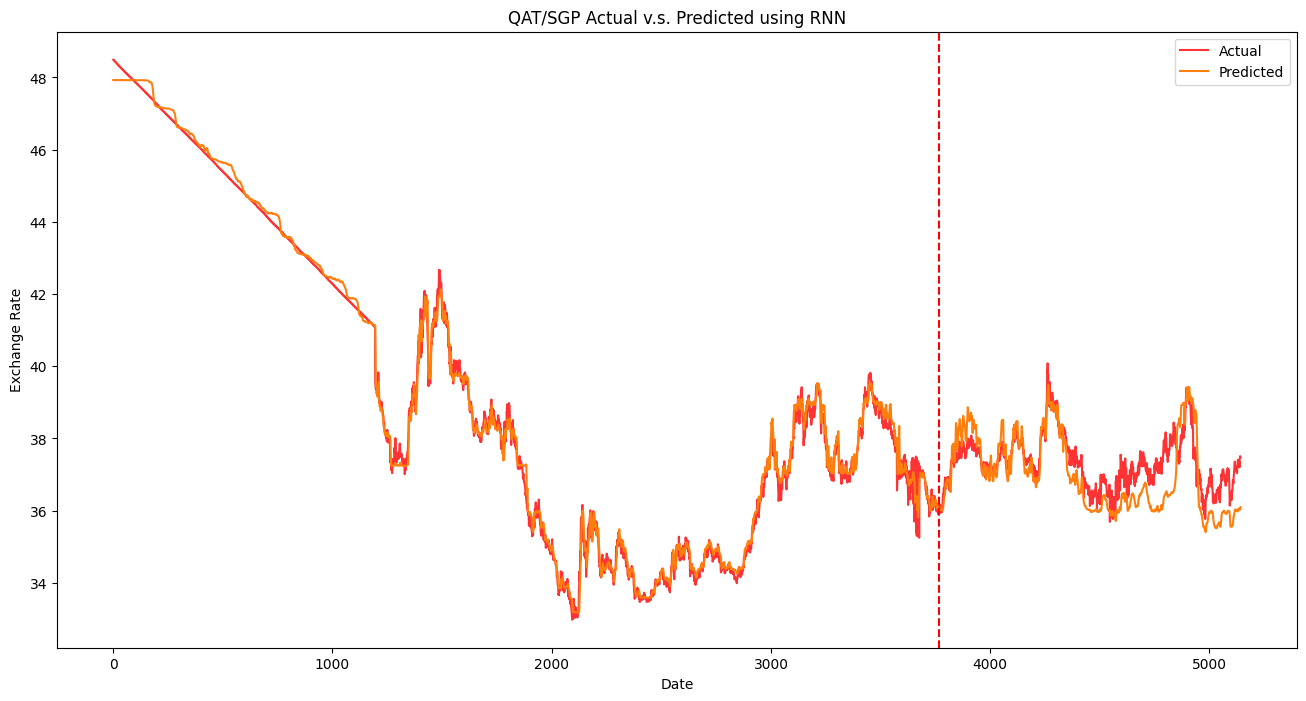

compute mae mse
mse: 0.47917, mae: 0.56877, R^2:0.06270436854345918 for forecast
mse_all: 0.17053, mae_all: 0.28252, R^2_all:0.9882657032694593 for forecast
{'QAT': [0.47916818, 0.5687707, 0.06270436854345918, 0.17053047, 0.28252417, 0.9882657032694593]}
loading data of SGD/QAT
loading other economic indices
normalization
   Oil_price  Gold_price  GDP_per_capita_QAT  GDP_per_capita_SGP  \
0  -1.533390   -1.773222           -1.730655           -1.730655   
1  -1.478721   -1.771751           -1.730197           -1.730197   
2  -1.519829   -1.756513           -1.728825           -1.728825   
3  -1.566022   -1.762293           -1.728368           -1.728368   
4  -1.588907   -1.760717           -1.727910           -1.727910   

   Net_trade_in_goods_QAT  Net_trade_in_goods_SGP  Net_financial_account_QAT  \
0                1.730655               -1.730655                   1.730655   
1                1.730197               -1.730197                   1.730197   
2                1.728825  

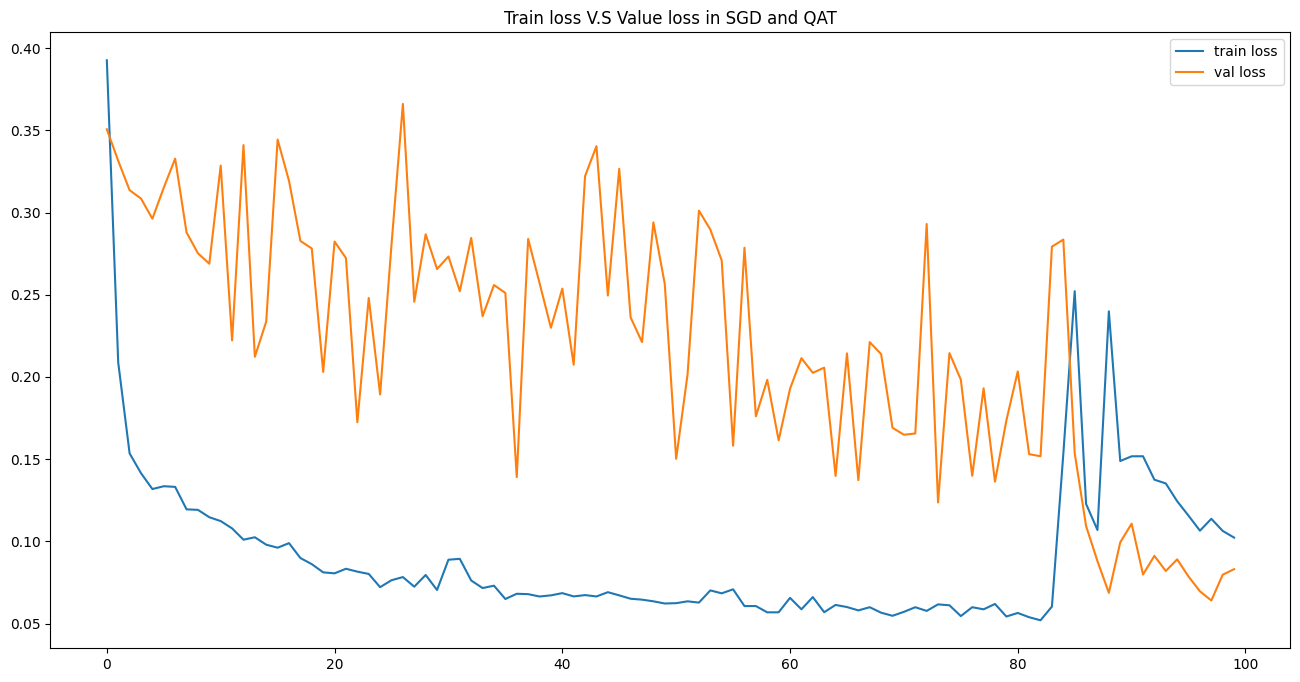

161/161 [==============================] - 2s 13ms/step
scale back to the original data
test plot


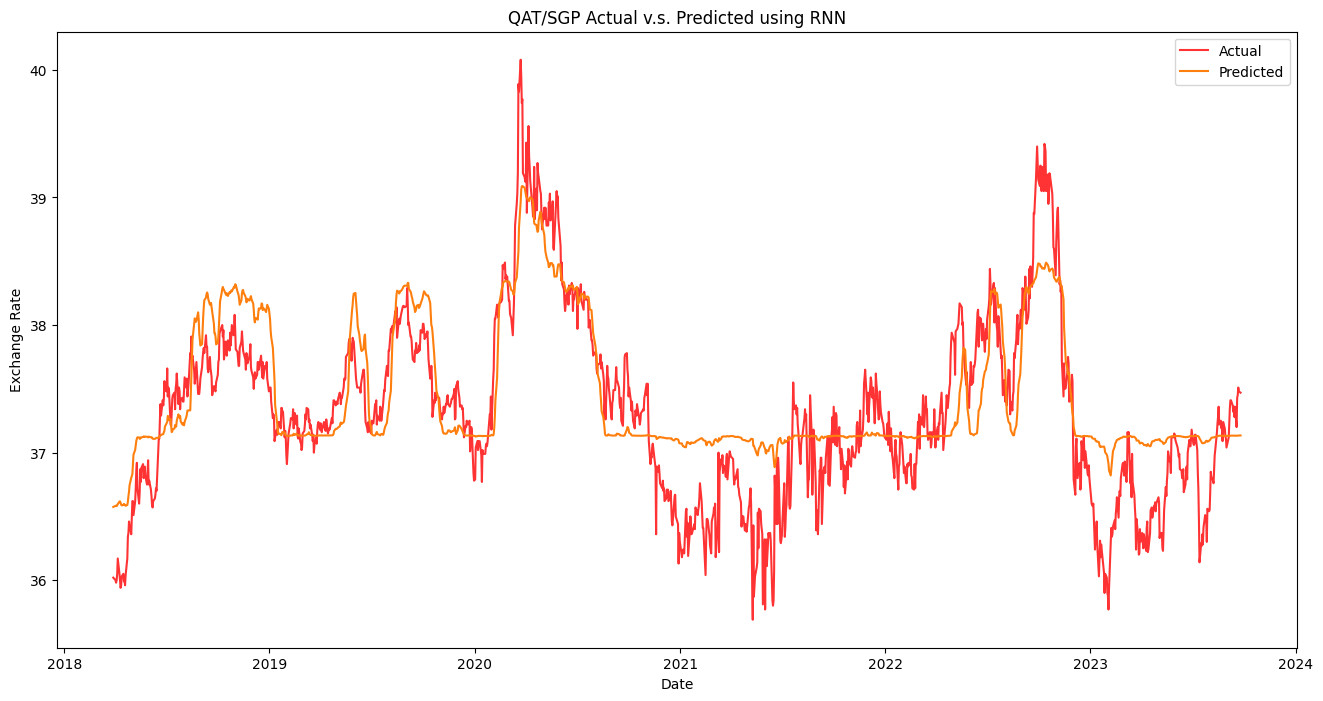

whole data plot


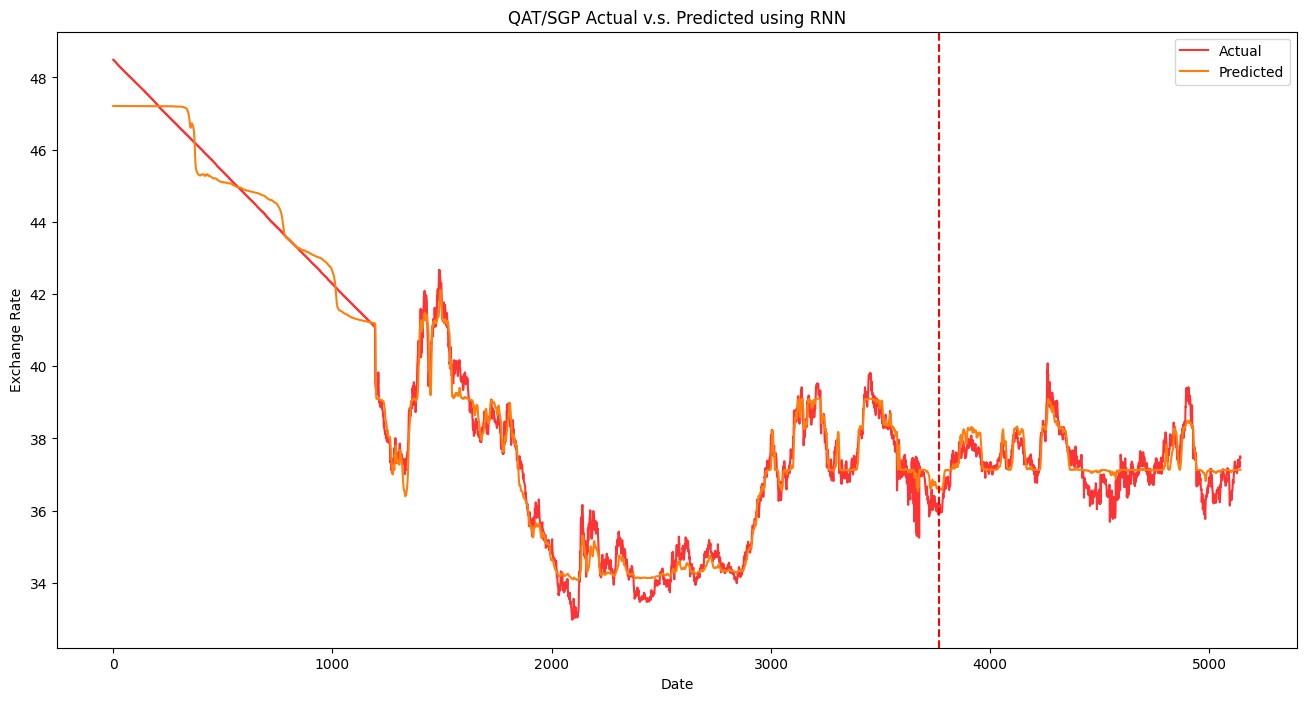

compute mae mse
mse: 0.16661, mae: 0.32697, R^2:0.6740874189704027 for forecast
mse_all: 0.17654, mae_all: 0.33049, R^2_all:0.9878522830308981 for forecast
{'QAT': [0.47916818, 0.5687707, 0.06270436854345918, 0.17053047, 0.28252417, 0.9882657032694593, 0.16661438, 0.32696667, 0.6740874189704027, 0.17653856, 0.33049092, 0.9878522830308981]}


In [44]:
tf.random.set_seed(51)
want_var_no_event= {
    'EUU': ['GDP_per_capita','Current_account_balance','Net_financial_account','Net_foreign_assets','Stockmarket_index','oil+gold'],
    'CHN': ['GDP_per_capita','Net_trade_in_goods','Net_foreign_assets','PPI','oil+gold'],
    'USA':['GDP_per_capita','Current_account_balance','Net_foreign_assets','Stocks_traded_turnover','Unemployment_perc_laborforce','CPI','oil+gold'],
    'SAU':['GDP_per_capita','Net_trade_in_goods','Net_foreign_assets','Stocks_traded_value','Unemployment_perc_laborforce','CPI','oil+gold'],
    'AUS':['GDP_per_capita','Current_account_balance','Net_foreign_assets','Stocks_traded_value','CPI','oil+gold'],
    'MYS':['GDP_per_capita','Exports_of_goods','Net_foreign_assets','Stocks_traded_turnover','Real_interest_rate','oil+gold'],
    'GBR':['GDP_per_capita','Imports_of_goods','CPI','Stockmarket_index','Real_interest_rate','oil+gold'],
    'CHE':['GDP_per_capita','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold'],
    'HKG': ['GDP_per_capita','Imports_of_goods','Current_account_balance','Stocks_traded_value','Unemployment_perc_laborforce','oil+gold'],
    'CAN':['GDP_per_capita','Exports_of_goods','Stockmarket_index','Real_interest_rate','oil+gold'],
    'NZL':['GDP_per_capita','Exports_of_goods','Net_trade_in_goods','Stocks_traded_value','CPI','oil+gold'],
    'IND':['GDP_per_capita','Imports_of_goods','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold'],
    'JPN':['GDP_per_capita','Exports_of_goods','Net_financial_account','Stockmarket_index','oil+gold'],
    'KOR':['GDP_per_capita','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold'],
    'IDN':['GDP_per_capita','Imports_of_goods','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold'],
    'PHL':['GDP_per_capita','Imports_of_goods','Current_account_balance','Stocks_traded_turnover','CPI','oil+gold'],
    'VNM':['GDP_per_capita','Exports_of_goods','Net_foreign_assets','Stocks_traded_value','Stocks_traded_turnover','Unemployment_perc_laborforce','oil+gold'],
    'QAT':['GDP_per_capita','Net_trade_in_goods','Net_financial_account','Net_foreign_assets','Stocks_traded_value','Stocks_traded_turnover','Unemployment_perc_laborforce','CPI','oil+gold'],
    'THA': ['GDP_per_capita','Exports_of_goods','Net_financial_account','oil+gold']
    }
want_var = {
    'EUU': ['GDP_per_capita','Current_account_balance','Net_financial_account','Net_foreign_assets','Stockmarket_index','oil+gold','Political_stability_estimate','Google_Insurance','Google_Crude','Google_Job'],
    'CHN': ['GDP_per_capita','Net_trade_in_goods','Net_foreign_assets','PPI','oil+gold','Control_of_Corruption','Government_Effectiveness','Regulatory_Quality','Voice_and _Accountability','Google_Inflation','Google_Stock','Google_Insurance','Google_Crude'],
    'USA':['GDP_per_capita','Current_account_balance','Net_foreign_assets','Stocks_traded_turnover','Political_stability_estimate','Unemployment_perc_laborforce','CPI','oil+gold','Google_Crude','Google_Job'],
    'SAU':['GDP_per_capita','Net_trade_in_goods','Net_foreign_assets','Stocks_traded_value','Political_stability_estimate','Unemployment_perc_laborforce','CPI','oil+gold','Google_Job'],
    'AUS':['GDP_per_capita','Current_account_balance','Net_foreign_assets','Stocks_traded_value','CPI','oil+gold','Control_of_Corruption','Government_Effectiveness','Regulatory_Quality','Voice_and _Accountability','Google_Inflation'],
    'MYS':['GDP_per_capita','Exports_of_goods','Net_foreign_assets','Stocks_traded_turnover','Real_interest_rate','oil+gold','Control_of_Corruption','Google_Inflation'],
    'GBR':['GDP_per_capita','Imports_of_goods','CPI','Stockmarket_index','Real_interest_rate','oil+gold','Political_stability_estimate','Voice_and _Accountability','Google_Crude','Google_Job'],
    'CHE':['GDP_per_capita','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold','Political_stability_estimate','Regulatory_Quality','Rule_of _Law','Google_Insurance','Google_Crude','Google_Job'],
    'HKG': ['GDP_per_capita','Imports_of_goods','Current_account_balance','Stocks_traded_value','Unemployment_perc_laborforce','oil+gold','Political_stability_estimate','Voice_and _Accountability','Google_Job'],
    'CAN':['GDP_per_capita','Exports_of_goods','Stockmarket_index','Real_interest_rate','oil+gold','Control_of_Corruption','Regulatory_Quality','Google_Inflation','Google_Stock','Google_Insurance'],
    'NZL':['GDP_per_capita','Exports_of_goods','Net_trade_in_goods','Stocks_traded_value','CPI','oil+gold','Control_of_Corruption','Google_Insurance','Google_Crude','Google_Job'],
    'IND':['GDP_per_capita','Imports_of_goods','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold','Political_stability_estimate','Google_Crude','Google_Job'],
    'JPN':['GDP_per_capita','Exports_of_goods','Net_financial_account','Stockmarket_index','oil+gold','Control_of_Corruption','Regulatory_Quality','Voice_and _Accountability'],
    'KOR':['GDP_per_capita','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold','Political_stability_estimate','Google_Job'],
    'IDN':['GDP_per_capita','Imports_of_goods','Net_trade_in_goods','Net_financial_account','Stocks_traded_value','oil+gold','Political_stability_estimate','Google_Crude','Google_Job'],
    'PHL':['GDP_per_capita','Imports_of_goods','Current_account_balance','Stocks_traded_turnover','CPI','oil+gold','Political_stability_estimate','Control_of_Corruption','Government_Effectiveness'],
    'VNM':['GDP_per_capita','Exports_of_goods','Net_foreign_assets','Stocks_traded_value','Stocks_traded_turnover','Unemployment_perc_laborforce','oil+gold','Political_stability_estimate','Regulatory_Quality','Google_Job'],
    'QAT':['GDP_per_capita','Net_trade_in_goods','Net_financial_account','Net_foreign_assets','Stocks_traded_value','Stocks_traded_turnover','Unemployment_perc_laborforce','CPI','oil+gold','Political_stability_estimate','Control_of_Corruption','Google_Job'],
    'THA': ['GDP_per_capita','Exports_of_goods','Net_financial_account','oil+gold','Control_of_Corruption','Government_Effectiveness','Google_Insurance','Google_Crude']

    }
colors = {
    'EUU':'#1f77b4',  # blue
    'Predict':'#ff7f0e',  # orange (predict)
    'USA':'#2ca02c',  # green
    'CHN':'#d62728',  # red
    'MYS':'#9467bd',  # purple
    'SAU':'#8c564b',  # brown
    'AUS':'#e377c2',  # pink
    'GBR':'#7f7f7f',  # gray
    'CAN':'#bcbd22',  # yellow-green
    'HKG':'#17becf',  # turquoise
    'IND':'#FF5733',  # coral
    'IDN':'#33FF57',  # lime
    'JPN':'#5733FF',  # indigo
    'KOR':'#FF33A1',  # hot pink
    'NZL':'#A1FF33',  # spring green
    'PHL':'#33A1FF',  # dodger blue
    'QAT':'#FF3333',  # light coral
    'CHE':'#33FFA1',  # medium spring green
    'THA':'#A133FF',  # dark violet
    'VNM':'#FFE333'   # goldenrod
}

for currency in header_list[:]: # loop through all 20 currencies
  # print(currency)
  if currency in ['QAT']:
    print(currency)
    matrix = {currency:[]}
    matrix = rnn_model_2(currency, data_set_frame, matrix, want_var_no_event[currency], 'no_event_')
    matrix = rnn_model_2(currency, data_set_frame, matrix, want_var[currency],'')
